In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 100)
from geopandas import GeoDataFrame
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import mapclassify as mc
# import pysal

from pysal.lib.weights import DistanceBand
from pysal.explore.esda.moran import Moran

from pysal.viz.splot.esda import lisa_cluster


#### color format = HH,HL,LH,LL,ns
colors_owner =['#AA29BE','#F4AFFE','#F9F6C5','#C0D160','white']
colors_investor = ['#FF7C00','#FFE1BF','#abd9e9','#6E93D1','white']

In [3]:
morans_hh_0010 = gpd.read_file("../00_data/PROCESSED/morans_hh_blocks_0010.geojson", driver='GeoJSON')
morans_hh_1018 = gpd.read_file("../00_data/PROCESSED/morans_hh_blocks_1018.geojson", driver='GeoJSON')

In [9]:
neighborhoods = gpd.read_file("../00_data/RAW/philadelphia/neighborhoods/neighborhoods.geojson")
city = gpd.read_file("../00_data/RAW/philadelphia/city_limits/City_Limits.geojson")


In [20]:
# loading other base layers for plots
water = gpd.read_file("../00_data/RAW/philadelphia/hyrdography/selected_water.geojson")
districts = gpd.read_file("../00_data/RAW/philadelphia/planning_districts/Planning_Districts.geojson")
city = gpd.read_file("../00_data/RAW/philadelphia/city_limits/City_Limits.geojson")
roads = gpd.read_file("../00_data/RAW/philadelphia/tl_2017_42101_roads/tl_2017_42101_roads.shp")
njroads = gpd.read_file("../00_data/RAW/philadelphia/tl_2015_34_prisecroads/nj_roads_select.geojson")
paroads = gpd.read_file("../00_data/RAW/philadelphia/tl_2014_42_prisecroads/penn_roads_select.geojson")
neighborhoods = gpd.read_file("../00_data/RAW/philadelphia/neighborhoods/neighborhoods.geojson")
# water_all = gpd.read_file("../00_data/RAW/philadelphia/hyrdography/Hydrographic_Features_Poly.geojson")


# reprojecting to philadelphia crs
districts = districts.to_crs({'init':'epsg:2272'})
roads = roads.to_crs({'init':'epsg:2272'})
city = city.to_crs({'init':'epsg:2272'})
njroads = njroads.to_crs({'init':'epsg:2272'})
paroads = paroads.to_crs({'init':'epsg:2272'})
# selecting just major roads
roads_formap = roads.loc[roads["RTTYP"] != 'M']
# selecting just minor roads
roads_minorformap = roads.loc[roads["RTTYP"] == 'M']

In [31]:
paroads_all = gpd.read_file("../00_data/RAW/philadelphia/tl_2014_42_prisecroads/tl_2014_42_prisecroads.shp")
njroads_all = gpd.read_file("../00_data/RAW/philadelphia/tl_2015_34_prisecroads/tl_2015_34_prisecroads.shp")


In [35]:
paroads_all = paroads_all.to_crs({'init':'epsg:2272'})
njroads_all = njroads_all.to_crs({'init':'epsg:2272'})

In [40]:
water_all = gpd.read_file("../00_data/RAW/philadelphia/hyrdography/Hydrographic_Features_Poly.geojson")


In [42]:
water_all = water_all.to_crs({'init':'epsg:2272'})

In [34]:
njroads_all.crs

{'init': 'epsg:4269'}

In [4]:
parks = gpd.read_file("../00_data/RAW/philadelphia/parks/PPR_Properties.geojson")

In [5]:
parks= parks.to_crs({'init':'epsg:2272'})

In [10]:
neighborhoods = neighborhoods.to_crs({'init':'epsg:2272'})

In [ ]:
# read in land use file
landuse = gpd.read_file("../00_data/RAW/philadelphia/land_use/Land_Use_2019/Land_Use.shp")
landuse = landuse[landuse.geometry.notnull()]
landuse = landuse.to_crs({'init':'epsg:2272'})
non_residential_novac = landuse[(landuse['C_DIG1DESC'] =='Park/Open Space')|
                          (landuse['C_DIG1DESC'] =='Industrial')| 
                          (landuse['C_DIG1DESC'] == 'Commercial') | 
                          (landuse['C_DIG1DESC'] == 'Civic/Institution')| 
                          (landuse['C_DIG1DESC'] =='Culture/Recreation')]

In [19]:
inv_hh = ['#FF7C00']
inv_hh_map = colors.ListedColormap(inv_hh)
occ_hh = ['#AA29BE']
# occ_hh = [(255,255,255,0),(0,0,0,1)]

occ_hh_map = colors.ListedColormap(occ_hh)

over = ['#00FFFF']
over_hh_map = colors.ListedColormap(over)


In [16]:

# creating overlap field that was missing
morans_hh_1018['overlap10_13'] = morans_hh_1018.apply(lambda x: 1 if (x.overlap10==1) 
                                                   or (x.overlap11==1)
                                                   or (x.overlap12==1)
                                                   or (x.overlap13==1) else 0,axis=1)
morans_hh_1018['overlap14_18'] = morans_hh_1018.apply(lambda x: 1 if (x.overlap14==1)
                                                   or (x.overlap15==1)
                                                   or (x.overlap16==1)
                                                   or (x.overlap17==1)
                                                   or (x.overlap18==1) else 0,axis=1)

In [18]:
occ_00_06 = morans_hh_0010.loc[morans_hh_0010['occ_00_06']==1].copy()
occ_07_09 = morans_hh_0010.loc[morans_hh_0010['occ_07_09']==1].copy()
inv_00_06 = morans_hh_0010.loc[morans_hh_0010['inv_00_06']==1].copy()
inv_07_09 = morans_hh_0010.loc[morans_hh_0010['inv_07_09']==1].copy()
over_00_06 = morans_hh_0010.loc[morans_hh_0010['overlap00_06']==1].copy()
over_07_09 = morans_hh_0010.loc[morans_hh_0010['overlap07_09']==1].copy()

occ_10_13 = morans_hh_1018.loc[morans_hh_1018['occ_10_13']==1].copy()
occ_14_18 = morans_hh_1018.loc[morans_hh_1018['occ_14_18']==1].copy()
inv_10_13 = morans_hh_1018.loc[morans_hh_1018['inv_10_13']==1].copy()
inv_14_18 = morans_hh_1018.loc[morans_hh_1018['inv_14_18']==1].copy()
over10_13 = morans_hh_1018.loc[morans_hh_1018['overlap10_13']==1].copy()
over14_18 = morans_hh_1018.loc[morans_hh_1018['overlap14_18']==1].copy()



In [24]:
over_00_06.head()

CBLK00_  investor_all2000  investor_all2001  investor_all2002  \
17     4773               0.0               0.0               2.0   
32     4407               0.0               0.0               2.0   
34     4465               0.0               0.0               1.0   
40     4668               0.0               2.0               0.0   
46     4895               1.0               0.0               1.0   

    investor_all2003  investor_all2004  investor_all2005  investor_all2006  \
17               1.0               2.0               1.0               1.0   
32               1.0               0.0               1.0               1.0   
34               3.0               0.0               3.0               3.0   
40               2.0               0.0               1.0               0.0   
46               2.0               1.0               0.0               0.0   

    investor_all2007  investor_all2008  investor_all2009  owner_occup2000  \
17               0.0               0.0               0.0              1.0   
32               0.0               0.0               1.0              4.0   
34               0.0               0.0               4.0              0.0   
40               0.0               1.0               2.0              2.0   
46               2.0               0.0               0.0              3.0   

    owner_occup2001  owner_occup2002  owner_occup2003  owner_occup2004  \
17              3.0              3.0              3.0              4.0   
32              2.0              2.0              6.0              6.0   
34              4.0              1.0              4.0              2.0   
40              3.0              4.0              4.0              6.0   
46              5.0              1.0              2.0              3.0   

    owner_occup2005  owner_occup2006  owner_occup2007  owner_occup2008  \
17              6.0              9.0              4.0              0.0   
32              3.0              0.0              7.0              1.0   
34              6.0              1.0              0.0              4.0   
40              6.0              4.0              1.0              3.0   
46              2.0              7.0              0.0              1.0   

    owner_occup2009  count_field2000  count_field2001  count_field2002  \
17              0.0              1.0              3.0              5.0   
32              0.0              4.0              2.0              4.0   
34              2.0              0.0              4.0              2.0   
40              3.0              2.0              5.0              4.0   
46              3.0              4.0              5.0              2.0   

    count_field2003  count_field2004  count_field2005  count_field2006  \
17              4.0              6.0              7.0             10.0   
32              7.0              6.0              4.0              1.0   
34              7.0              2.0              9.0              4.0   
40              6.0              6.0              7.0              4.0   
46              4.0              4.0              2.0              7.0   

    count_field2007  count_field2008  count_field2009  res_parcel_num  \
17              4.0              0.0              0.0              59   
32              7.0              1.0              1.0              45   
34              0.0              4.0              6.0              48   
40              1.0              4.0              5.0              39   
46              2.0              1.0              3.0              39   

    per_inv_2000  per_inv_2001  per_inv_2002  per_inv_2003  per_inv_2004  \
17      0.000000      0.000000      0.033898      0.016949      0.033898   
32      0.000000      0.000000      0.044444      0.022222      0.000000   
34      0.000000      0.000000      0.020833      0.062500      0.000000   
40      0.000000      0.051282      0.000000      0.051282      0.000000   
46      0.025641      0.000000      0.025641      0.051282

In [13]:
xlim = ([city.total_bounds[0],city.total_bounds[2]])
ylim = ([city.total_bounds[1],city.total_bounds[3]])

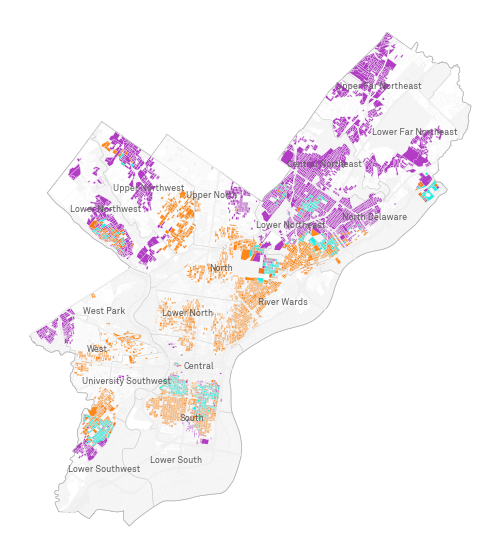

In [125]:
fig, ax = plt.subplots(figsize=(10,10))
# morans_hh_0010.plot(color='white',edgecolor='#E6E6E6',linewidth=0.1,ax=ax,)

occ_00_06.plot(column="occ_00_06",cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
inv_00_06.plot(column="inv_00_06",cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)

over_00_06.plot(column="overlap00_06",cmap=over_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

# water.plot(ax=ax, color="#000000", edgecolor='none', alpha=.1)
# # paroads.plot(ax=ax, color="lightgrey", linewidth=.5, alpha=0.3)
# # njroads.plot(ax=ax, color="lightgrey",  linewidth=.5,  alpha=0.3)
# roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
# roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)

# water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
roads_formap.plot(ax=ax, color="#F0F0F0",);
districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], 
                                      ha='center',fontname="Akkurat Pro", fontsize=9,color='#5A5A5A'),axis=1);    
city.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# plt.savefig("test.svg")
ax.set_axis_off()

# plt.show()
plt.savefig("../05_drawings/morans/hh_0006.png",dpi=500)


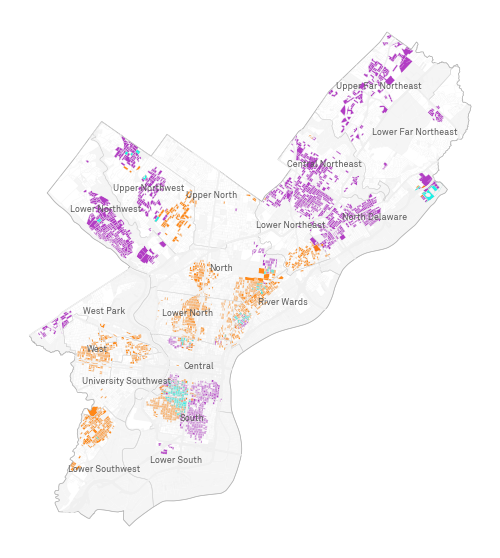

In [128]:
fig, ax = plt.subplots(figsize=(10,10))
# morans_hh_0010.plot(color='white',edgecolor='#E6E6E6',linewidth=0.1,ax=ax,)

occ_07_09.plot(column="occ_07_09",cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
inv_07_09.plot(column="inv_07_09",cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
over_07_09.plot(column="overlap07_09",cmap=over_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)

non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')
# water.plot(ax=ax, color="#000000", edgecolor='none', alpha=.1)
# # paroads.plot(ax=ax, color="lightgrey", linewidth=.5, alpha=0.3)
# # njroads.plot(ax=ax, color="lightgrey",  linewidth=.5,  alpha=0.3)
# roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
# roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)

# water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
roads_formap.plot(ax=ax, color="#F0F0F0",);
districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], 
                                      ha='center',fontname="Akkurat Pro", fontsize=9,color='#5A5A5A'),axis=1);    
city.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
ax.set_axis_off()

# plt.show()
plt.savefig("../05_drawings/morans/hh_0709.png",dpi=500)


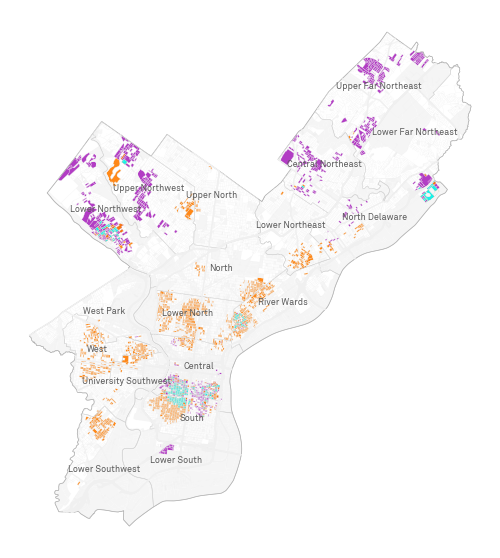

In [127]:
fig, ax = plt.subplots(figsize=(10,10))
# morans_hh_0010.plot(color='white',edgecolor='#E6E6E6',linewidth=0.1,ax=ax,)

occ_10_13.plot(column="occ_10_13",cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
inv_10_13.plot(column="inv_10_13",cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
over10_13.plot(column="overlap10_13",cmap=over_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')


# water.plot(ax=ax, color="#000000", edgecolor='none', alpha=.1)
# # paroads.plot(ax=ax, color="lightgrey", linewidth=.5, alpha=0.3)
# # njroads.plot(ax=ax, color="lightgrey",  linewidth=.5,  alpha=0.3)
# roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
# roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)

# water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
roads_formap.plot(ax=ax, color="#F0F0F0",);
districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], 
                                      ha='center',fontname="Akkurat Pro", fontsize=9,color='#5A5A5A'),axis=1);    
city.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# plt.savefig("test.svg")
ax.set_axis_off()

# plt.show()
plt.savefig("../05_drawings/morans/hh_1013.png",dpi=500)


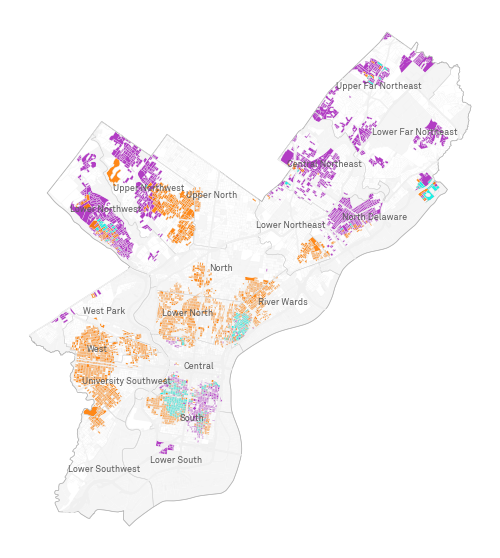

In [126]:
fig, ax = plt.subplots(figsize=(10,10))
# morans_hh_0010.plot(color='white',edgecolor='#E6E6E6',linewidth=0.1,ax=ax,)

occ_14_18.plot(column="occ_14_18",cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
inv_14_18.plot(column="inv_14_18",cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
over14_18.plot(column="overlap14_18",cmap=over_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

# water.plot(ax=ax, color="#000000", edgecolor='none', alpha=.1)
# # paroads.plot(ax=ax, color="lightgrey", linewidth=.5, alpha=0.3)
# # njroads.plot(ax=ax, color="lightgrey",  linewidth=.5,  alpha=0.3)
# roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
# roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)

# water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
roads_formap.plot(ax=ax, color="#F0F0F0",);
districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], 
                                      ha='center',fontname="Akkurat Pro", fontsize=9,color='#5A5A5A'),axis=1);    
city.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
ax.set_axis_off()

plt.savefig("../05_drawings/morans/hh_1418.png",dpi=500)

# plt.show()

In [106]:
districts.head()

OBJECTID_1  OBJECTID             DIST_NAME ABBREV   Shape__Area  \
0           1        14           River Wards     RW  2.107270e+08   
1           2         3        North Delaware   NDEL  2.700915e+08   
2           3         0   Lower Far Northeast   LFNE  3.068529e+08   
3           4         9               Central    CTR  1.782880e+08   
4           5        10  University Southwest    USW  1.296468e+08   

   Shape__Length                                           geometry  
0   66931.595020  POLYGON ((2711324.187 255818.543, 2710945.048 ...  
1   89213.074378  POLYGON ((2743358.361 274541.477, 2743291.495 ...  
2   92703.285159  POLYGON ((2747427.990 297865.355, 2747378.608 ...  
3   71405.143450  POLYGON ((2697746.714 241702.374, 2697526.198 ...  
4   65267.676141  POLYGON ((2686720.003 239937.390, 2686549.912 ...

NameError: name 'occ_00_06' is not defined

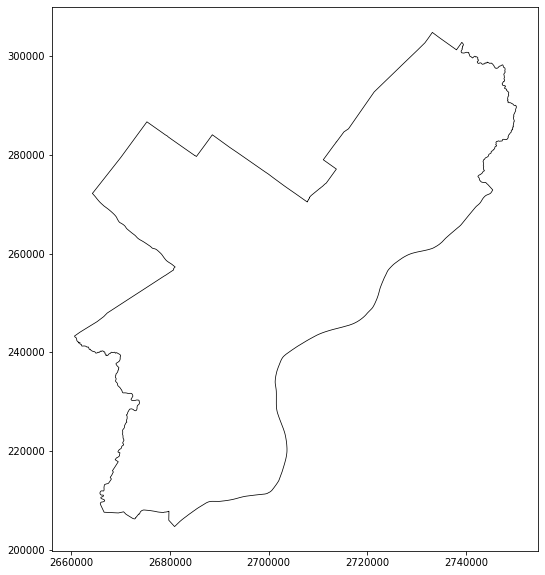

In [111]:
fig, ax = plt.subplots(figsize=(10,10))
# morans_hh_0010.plot(color='white',edgecolor='#E6E6E6',linewidth=0.1,ax=ax,)
city.plot(ax=ax, color="white", edgecolor="k", linewidth=.75)
occ_00_06.plot(column="occ_00_06",cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,)
inv_00_06.plot(column="inv_00_06",cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.8)
water.plot(ax=ax, color="#000000", edgecolor='none', alpha=.6)
# paroads.plot(ax=ax, color="lightgrey", linewidth=.5, alpha=0.3)
# njroads.plot(ax=ax, color="lightgrey",  linewidth=.5,  alpha=0.3)
roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# plt.savefig("test.svg")
ax.set_axis_off()

In [8]:
colors_investor = ['#FF7C00','#FFE1BF','#abd9e9','#6E93D1','white']
hmap = colors.ListedColormap(colors_investor)

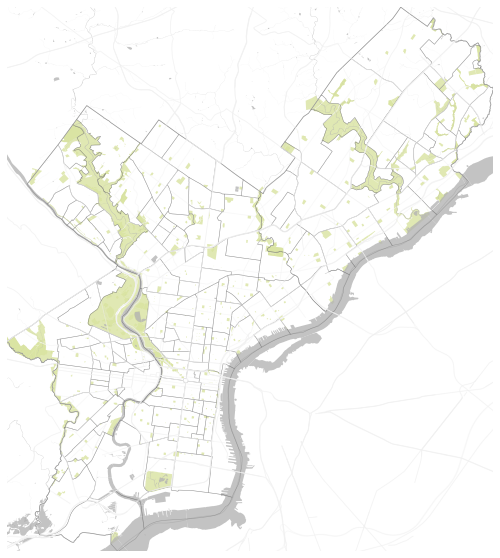

In [210]:
fig, ax = plt.subplots(figsize=(10,10))
# morans_hh_0010.plot(color='white',edgecolor='#E6E6E6',linewidth=0.1,ax=ax,)

# occ_10_13.plot(column="occ_10_13",cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
# inv_10_13.plot(column="inv_10_13",cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
# water.plot(ax=ax, color="#000000", edgecolor='none', alpha=.1)
paroads.plot(ax=ax, color="#F0F0F0",alpha=0.5,linewidth=0.75)
njroads.plot(ax=ax, color="#F0F0F0",alpha=0.5,linewidth=0.75)
# roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
# roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)
parks.plot(ax=ax,color="#D9E3A0",edgecolor='none', alpha=0.8)
water.plot(ax=ax, color="#B4B4B4", edgecolor='none', alpha=0.8);
# roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, alpha=0.8 );
# roads_formap.plot(ax=ax, color="#F0F0F0",alpha=0.5);
# districts.plot(ax=ax,facecolor='none',edgecolor='#5A5A5A',linewidth=0.5)
# districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], 
#                                       ha='center',fontname="Akkurat Pro", fontsize=9,color='#5A5A5A'),axis=1);    
city.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)
neighborhoods.plot(ax=ax,facecolor='none',edgecolor='#5A5A5A',linewidth=0.5,alpha=0.4)

# neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], 
#                                       ha='center',fontname="Akkurat Pro", fontsize=3,color='#5A5A5A'),axis=1);    
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# plt.savefig("test.svg")
ax.set_axis_off()

# plt.show()
plt.savefig("02_outputs/complete_drafts/orienting/neighborhoods-1.png",dpi=500)


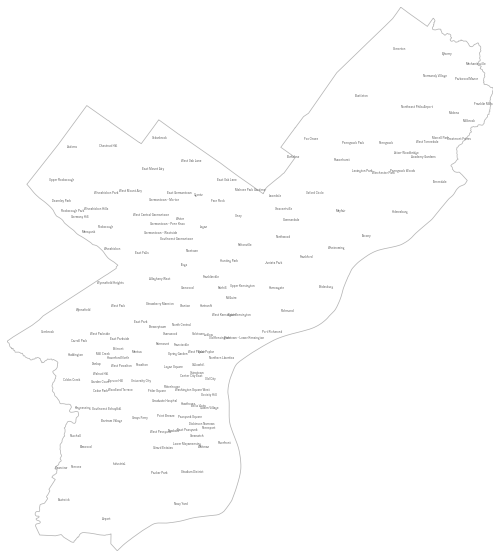

In [222]:
# import matplotlib.cbook as cbook
# from matplotlib_scalebar.scalebar import ScaleBar

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

fig, ax = plt.subplots(figsize=(10,10))

# districts.plot(ax=ax,facecolor='none',edgecolor='#5A5A5A',linewidth=0.5)
# districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], 
#                                       ha='center',fontname="Akkurat Pro", fontsize=9,color='#5A5A5A'),axis=1);    
city.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)
# neighborhoods.plot(ax=ax,facecolor='none',edgecolor='#5A5A5A',linewidth=0.5,alpha=0.4)

neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], 
                                      ha='center',fontname="Akkurat Pro", fontsize=3,color='#5A5A5A'),axis=1);    
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# plt.savefig("test.svg")
ax.set_axis_off()
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           2000, '20 ft', 'lower center', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

# scalebar = ScaleBar(1,units='m')
# plt.gca().add_artist(scalebar)
plt.show()
# plt.savefig("02_outputs/complete_drafts/orienting/neighborhoods-1_names.svg")


In [9]:
deeds = gpd.read_file("../00_data/PROCESSED/realestate_tax_transfers/rtt_investors_classified.geojson")
deeds.crs = {'init':'epsg:2272'}

In [10]:
deeds['sort_year_x'] = deeds['sort_year_x'].astype(int)

In [11]:
deeds.head()


id C_DIG1   C_DIG1DESC C_DIG2          C_DIG2DESC C_DIG3  \
0  0      1  Residential     12  Residential Medium    121   
1  1      1  Residential     11     Residential Low    112   
2  2      1  Residential     12  Residential Medium    121   
3  3      1  Residential     12  Residential Medium    121   
4  4      1  Residential     11     Residential Low    111   

                 C_DIG3DESC  OBJECTID   Shape__Are  Shape__Len       VACBLDG  \
0      Residential Rowhouse   7744699   952.673950  165.045972  Fully Vacant   
1  Residential SemiDetached   7744935  3395.618225  298.879760          None   
2      Residential Rowhouse   7744943  1717.321350  237.627137          None   
3      Residential Rowhouse   7744945  1555.363403  195.088770          None   
4      Residential Detached   7744231  6734.606567  352.840272          None   

   YEAR  address_high  address_low address_low_frac address_low_suffix  \
0  2014           NaN       3083.0             None               None   
1  2016           NaN       3631.0             None               None   
2  2015           NaN       3430.0             None               None   
3  2012           NaN       5809.0             None               None   
4  2013           NaN       1403.0             None               None   

   adjusted_assessed_value  adjusted_cash_consideration  \
0                      NaN                      58900.0   
1                      NaN                      92000.0   
2                      NaN                     123000.0   
3                      NaN                      93000.0   
4                      NaN                      68500.0   

   adjusted_fair_market_value  adjusted_local_tax_amount  \
0                    30699.84                     1767.0   
1                    63936.00                     2760.0   
2                    43066.56                     3690.0   
3                    45344.64                     2790.0   
4                   305913.60                     2055.0   

   adjusted_other_consideration  adjusted_state_tax_amount  \
0                           NaN                      589.0   
1                           NaN                      920.0   
2                           NaN                     1230.0   
3                           NaN                      930.0   
4                           NaN                      685.0   

   adjusted_total_consideration  assessed_value  cash_consideration  \
0                       58900.0             NaN             58900.0   
1                       92000.0             NaN             92000.0   
2                      123000.0             NaN            123000.0   
3                       93000.0             NaN             93000.0   
4                       68500.0             NaN             68500.0   

   common_level_ratio condo_name discrepancy display_date_x display_date_y  \
0                 NaN       None          no     2004-04-02            NaT   
1                 NaN       None          no     2000-05-25            NaT   
2                 NaN       None          no     2004-05-28            NaT   
3                 NaN       None          no     2004-05-28            NaT   
4                 NaN       None          no     2004-05-12            NaT   

  document_date  document_id document_type              elapsed  elapsed_days  \
0    2004-04-02     50942296          DEED -9223372036854775808           NaN   
1    2000-05-25     50092387          DEED -9223372036854775808           NaN   
2    2004-05-28     50942514          DEED -9223372036854775808           NaN   
3    2004-05-28     50942516          DEED -9223372036854775808           NaN   
4    2004-05-12     50941882          DEED -9223372036854775808           NaN   

   fair_market_value       grantees_x_x grantees_x_y  grantees_y  \
0           30699.84    IRWIN LEIGHANNE         None       False   
1           63936.00  FALLEN PAUL J III         None       False   
2           43066.56      R

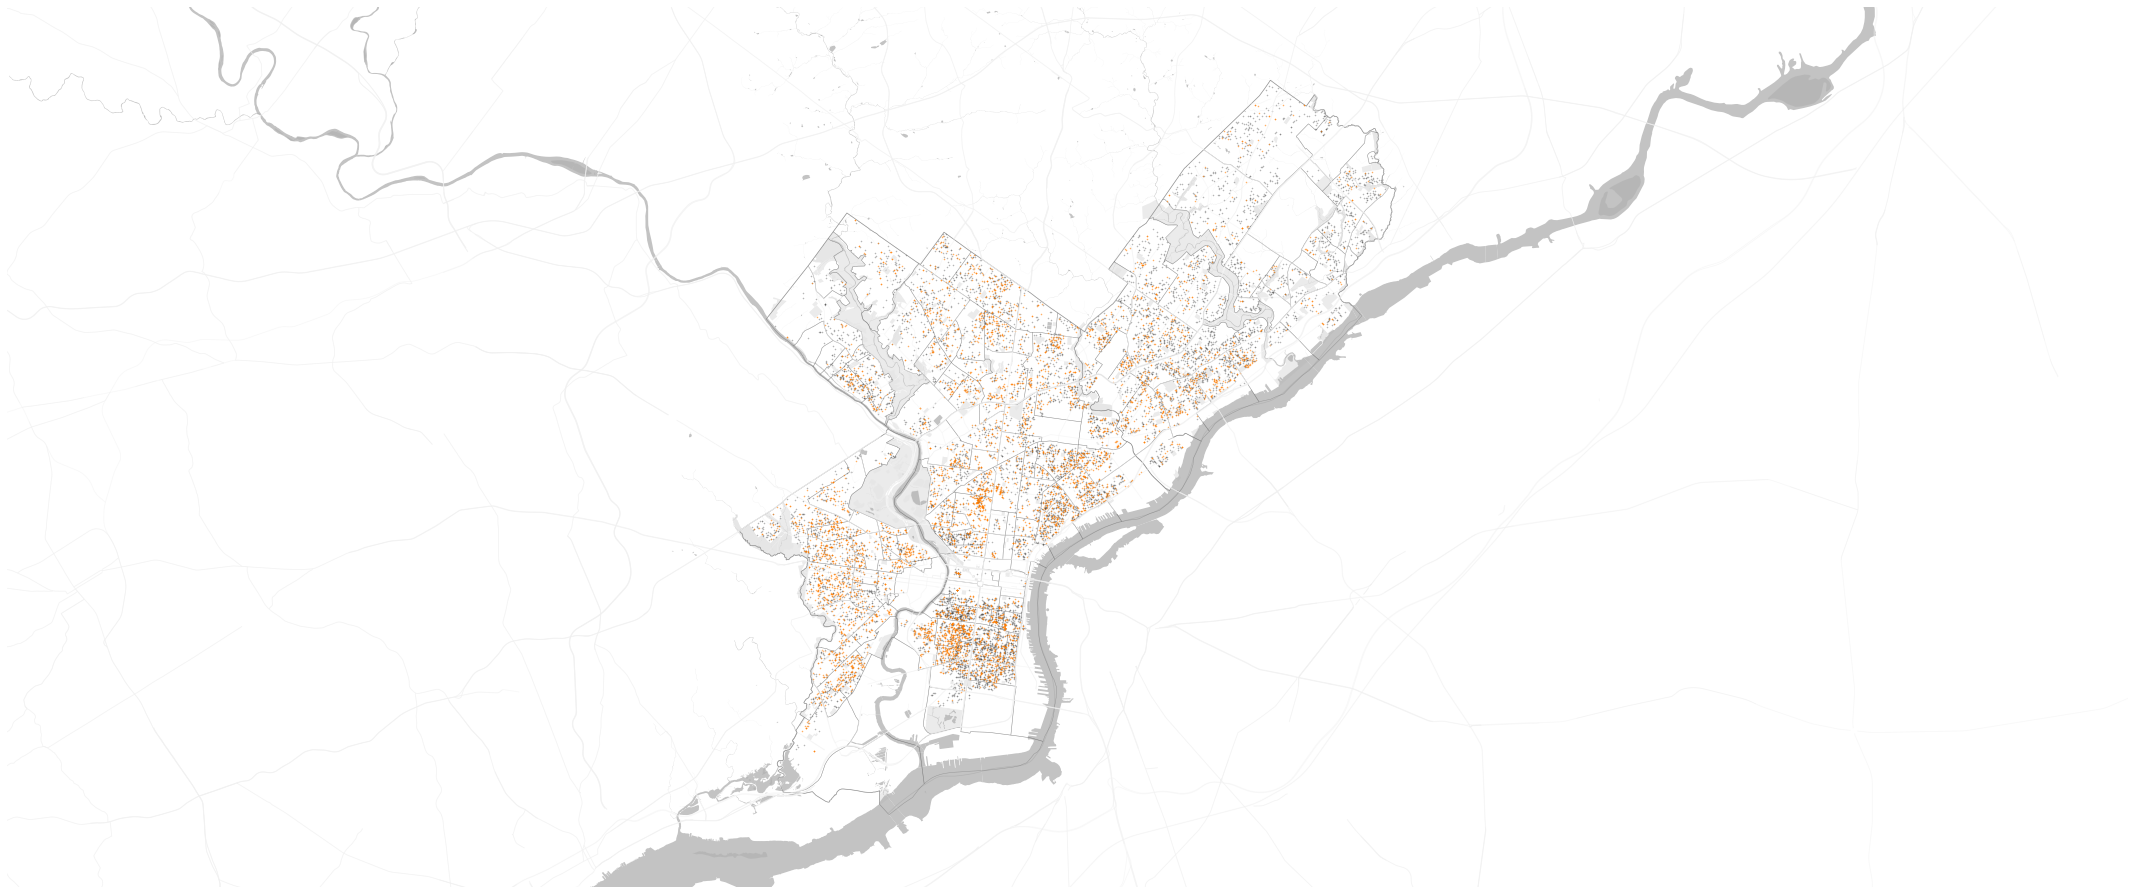

In [110]:
fig, ax = plt.subplots(figsize=(38,20))
# morans_hh_0010.plot(color='white',edgecolor='#E6E6E6',linewidth=0.1,ax=ax,)
ax.set_facecolor("black")
# occ_10_13.plot(column="occ_10_13",cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
# inv_10_13.plot(column="inv_10_13",cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
# water.plot(ax=ax, color="#000000", edgecolor='none', alpha=.1)
paroads_all.plot(ax=ax, color="#F0F0F0",alpha=0.5,linewidth=0.75)
njroads_all.plot(ax=ax, color="#F0F0F0",alpha=0.5,linewidth=0.75)
# roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
# roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)
parks.plot(ax=ax,color="#E6E6E6",edgecolor='none', alpha=0.8)
water_all.plot(ax=ax, color="#B4B4B4", edgecolor='none', alpha=0.8);
# roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, alpha=0.8 );
# roads_formap.plot(ax=ax, color="#F0F0F0",alpha=0.5);
# districts.plot(ax=ax,facecolor='none',edgecolor='#5A5A5A',linewidth=0.5)
# districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], 
#                                       ha='center',fontname="Akkurat Pro", fontsize=9,color='#5A5A5A'),axis=1);    
city.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)
neighborhoods.plot(ax=ax,facecolor='none',edgecolor='#5A5A5A',linewidth=0.5,alpha=0.4)

# neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], 
#                                       ha='center',fontname="Akkurat Pro", fontsize=3,color='#5A5A5A'),axis=1);    
deeds[(deeds['sort_year_x']==2011) & (deeds['investor_all']==0)].plot(ax=ax,color="#4D4D4D",markersize=0.3,alpha=0.4)

deeds[(deeds['sort_year_x']==2011) & (deeds['investor_all']==1)].plot(ax=ax,color="#FF7C00",markersize=0.3,alpha=0.6)

ax.set_xlim(xlim_wide)
ax.set_ylim(ylim_wide)
# plt.savefig("test.svg")
ax.set_axis_off()

# plt.show()
plt.savefig("../05_drawings/absolute_numbers/2011_investor_purchases_wide.png",dpi=500)


In [58]:
xlim_wide = ([city.total_bounds[0]-100000,city.total_bounds[2]+100000])
ylim_wide = ([city.total_bounds[1]-10000,city.total_bounds[3]+10000])

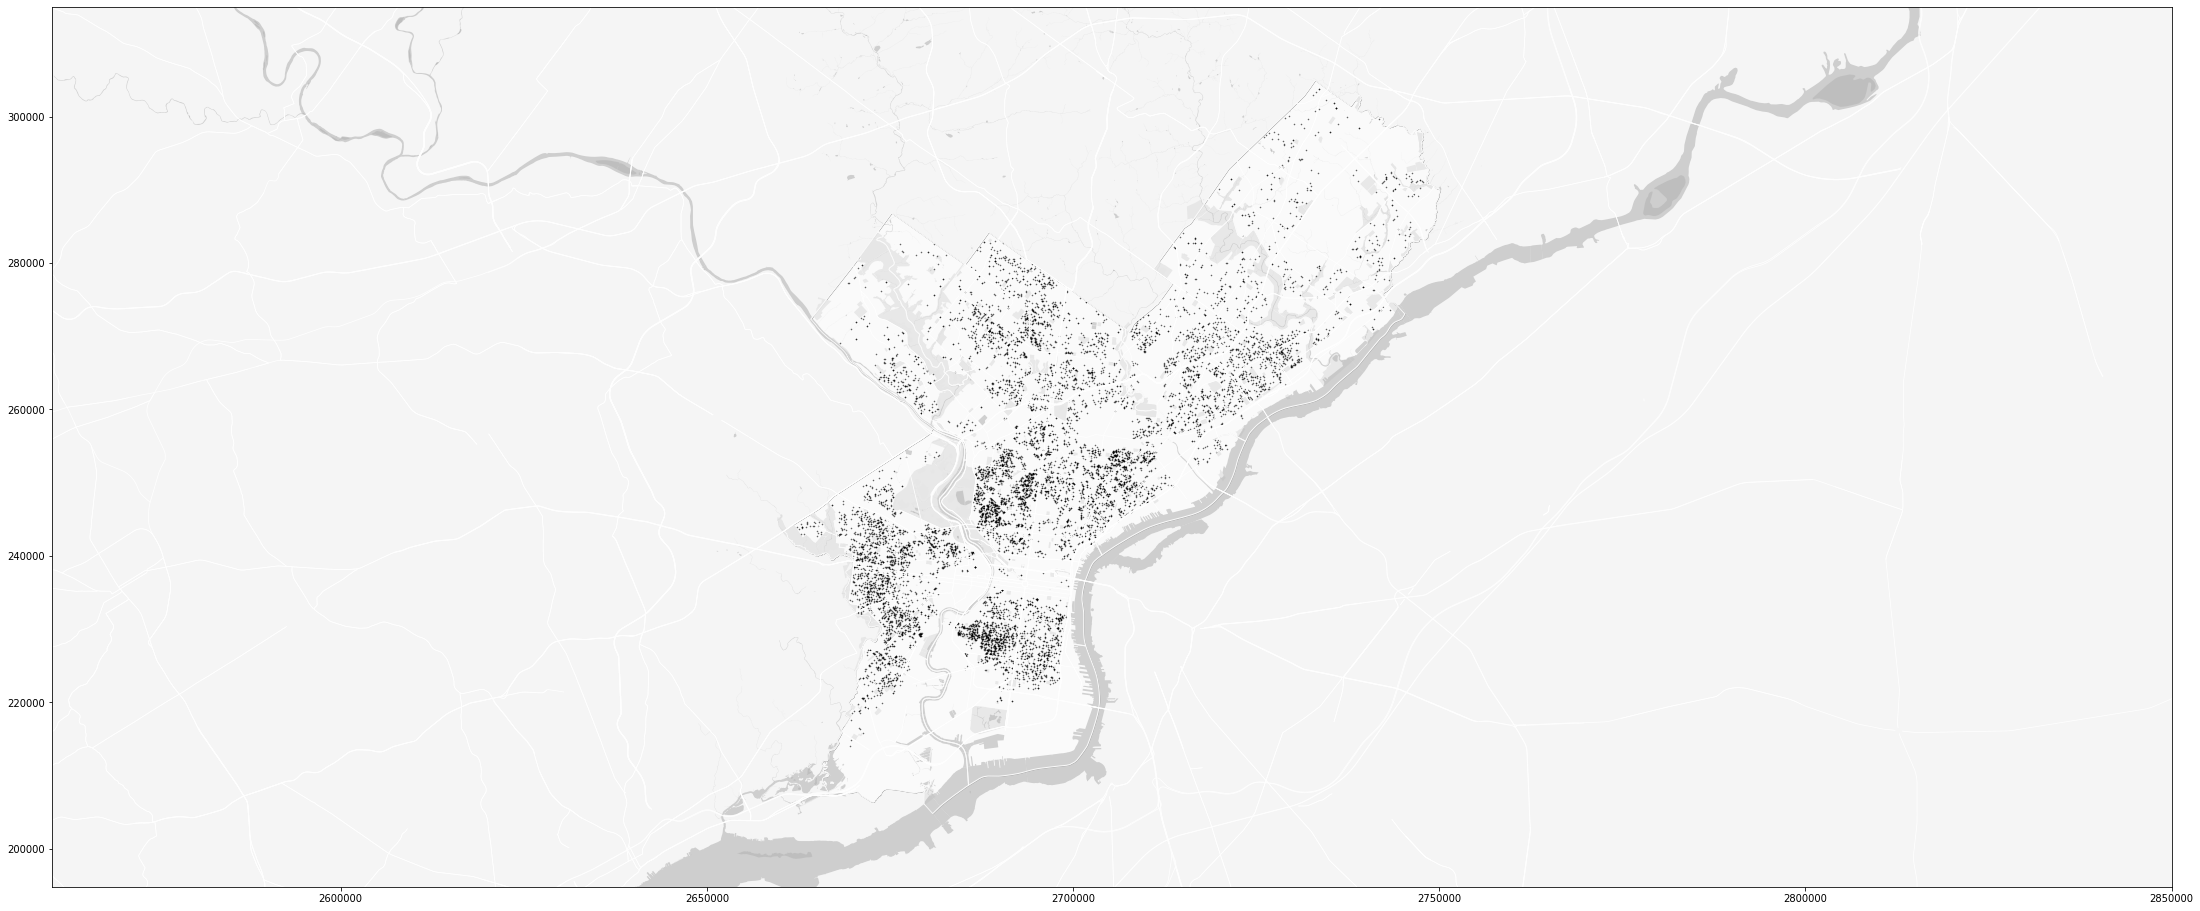

In [92]:
fig, ax = plt.subplots(figsize=(38,20))
# morans_hh_0010.plot(color='white',edgecolor='#E6E6E6',linewidth=0.1,ax=ax,)
ax.set_facecolor("whitesmoke")

paroads_all.plot(ax=ax, color="white",alpha=1,linewidth=0.75)
njroads_all.plot(ax=ax, color="white",alpha=1,linewidth=0.75)
# roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
# roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)
city.plot(ax=ax, color="white", edgecolor="k", linewidth=.5,alpha=0.5)
parks.plot(ax=ax,color="#E6E6E6",edgecolor='none', alpha=0.9)
water_all.plot(ax=ax, color="#B4B4B4", edgecolor='none', alpha=0.6);

# deeds[(deeds['sort_year_x']==2018)].plot(ax=ax,color="black",markersize=0.3,alpha=0.6)

deeds[(deeds['sort_year_x']==2018) & (deeds['investor_all']==1)].plot(ax=ax,color="black",markersize=0.3,alpha=0.6)
districts.plot(ax=ax,facecolor='none',edgecolor='#FAFAFA',linewidth=1, alpha=1);

# districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], 
#                                       ha='center',fontname="Akkurat Pro", backgroundcolor = "white",fontsize=8,color='#5A5A5A',alpha=0.2),axis=1); 



ax.set_xlim(xlim_wide)
ax.set_ylim(ylim_wide)
plt.savefig("../05_drawings/absolute_numbers/2018_invstors_wide.png",dpi=500)

# ax.set_axis_off()

In [ ]:
# fig, ax = plt.subplots(figsize=(10,10))
# morans_hh_0010.plot(color='white',edgecolor='#E6E6E6',linewidth=0.1,ax=ax,)

# occ_10_13.plot(column="occ_10_13",cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
# inv_10_13.plot(column="inv_10_13",cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
# water.plot(ax=ax, color="#000000", edgecolor='none', alpha=.1)
paroads.plot(ax=ax, color="#F0F0F0",alpha=0.5,linewidth=0.75)
njroads.plot(ax=ax, color="#F0F0F0",alpha=0.5,linewidth=0.75)
# roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
# roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)
parks.plot(ax=ax,color="#D9E3A0",edgecolor='none', alpha=0.8)
water.plot(ax=ax, color="#B4B4B4", edgecolor='none', alpha=0.8);
# roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, alpha=0.8 );
# roads_formap.plot(ax=ax, color="#F0F0F0",alpha=0.5);
# districts.plot(ax=ax,facecolor='none',edgecolor='#5A5A5A',linewidth=0.5)
# districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], 
#                                       ha='center',fontname="Akkurat Pro", fontsize=9,color='#5A5A5A'),axis=1);    
city.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)
neighborhoods.plot(ax=ax,facecolor='none',edgecolor='#5A5A5A',linewidth=0.5,alpha=0.4)

# neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], 
#                                       ha='center',fontname="Akkurat Pro", fontsize=3,color='#5A5A5A'),axis=1);    
deeds[(deeds['sort_year_x']==2018)].plot(ax=ax,color="#4D4D4D",markersize=0.3,alpha=0.6)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
# plt.savefig("test.svg")
ax.set_axis_off()

# plt.show()
plt.savefig("../05_drawings/absolute_numbers/2018_allpurchases.png",dpi=500)


In [104]:
grouped_deeds = gpd.read_file("../00_data/PROCESSED/grouped_deeds10_18_i_blocks.geojson")

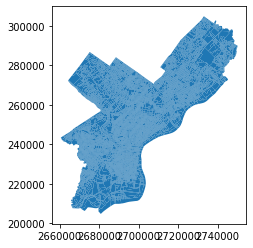

In [107]:
grouped_deeds.plot()

In [115]:
northphilly = districts.loc[(districts['DIST_NAME']=='North') | 
                                     (districts['DIST_NAME']=='Lower North')].copy()

westPhilly = neighborhoods.loc[neighborhoods['alt_name'] == 'West Philadelphia'].copy()

germantown = neighborhoods.loc[neighborhoods['alt_name']=='Germantown Area'].copy()

In [122]:
northphilly['dissolve'] = 2

In [135]:
northphilly = northphilly.dissolve(by='dissolve')
westPhilly = westPhilly.dissolve(by='alt_name').reset_index()
germantown = germantown.dissolve(by='alt_name').reset_index()

In [136]:
westPhilly

alt_name                                           geometry  \
0  West Philadelphia  POLYGON ((2681071.321 233354.460, 2680970.185 ...   

        name   listname    mapname    shape_leng    shape_area  cartodb_id  \
0  OVERBROOK  Overbrook  Overbrook  57004.924607  7.692499e+07         138   

            created_at           updated_at  
0  2013-03-19T17:41:50  2013-03-19T17:41:50

In [130]:
northphilly['DIST_NAME'] = "North Philadelphia"

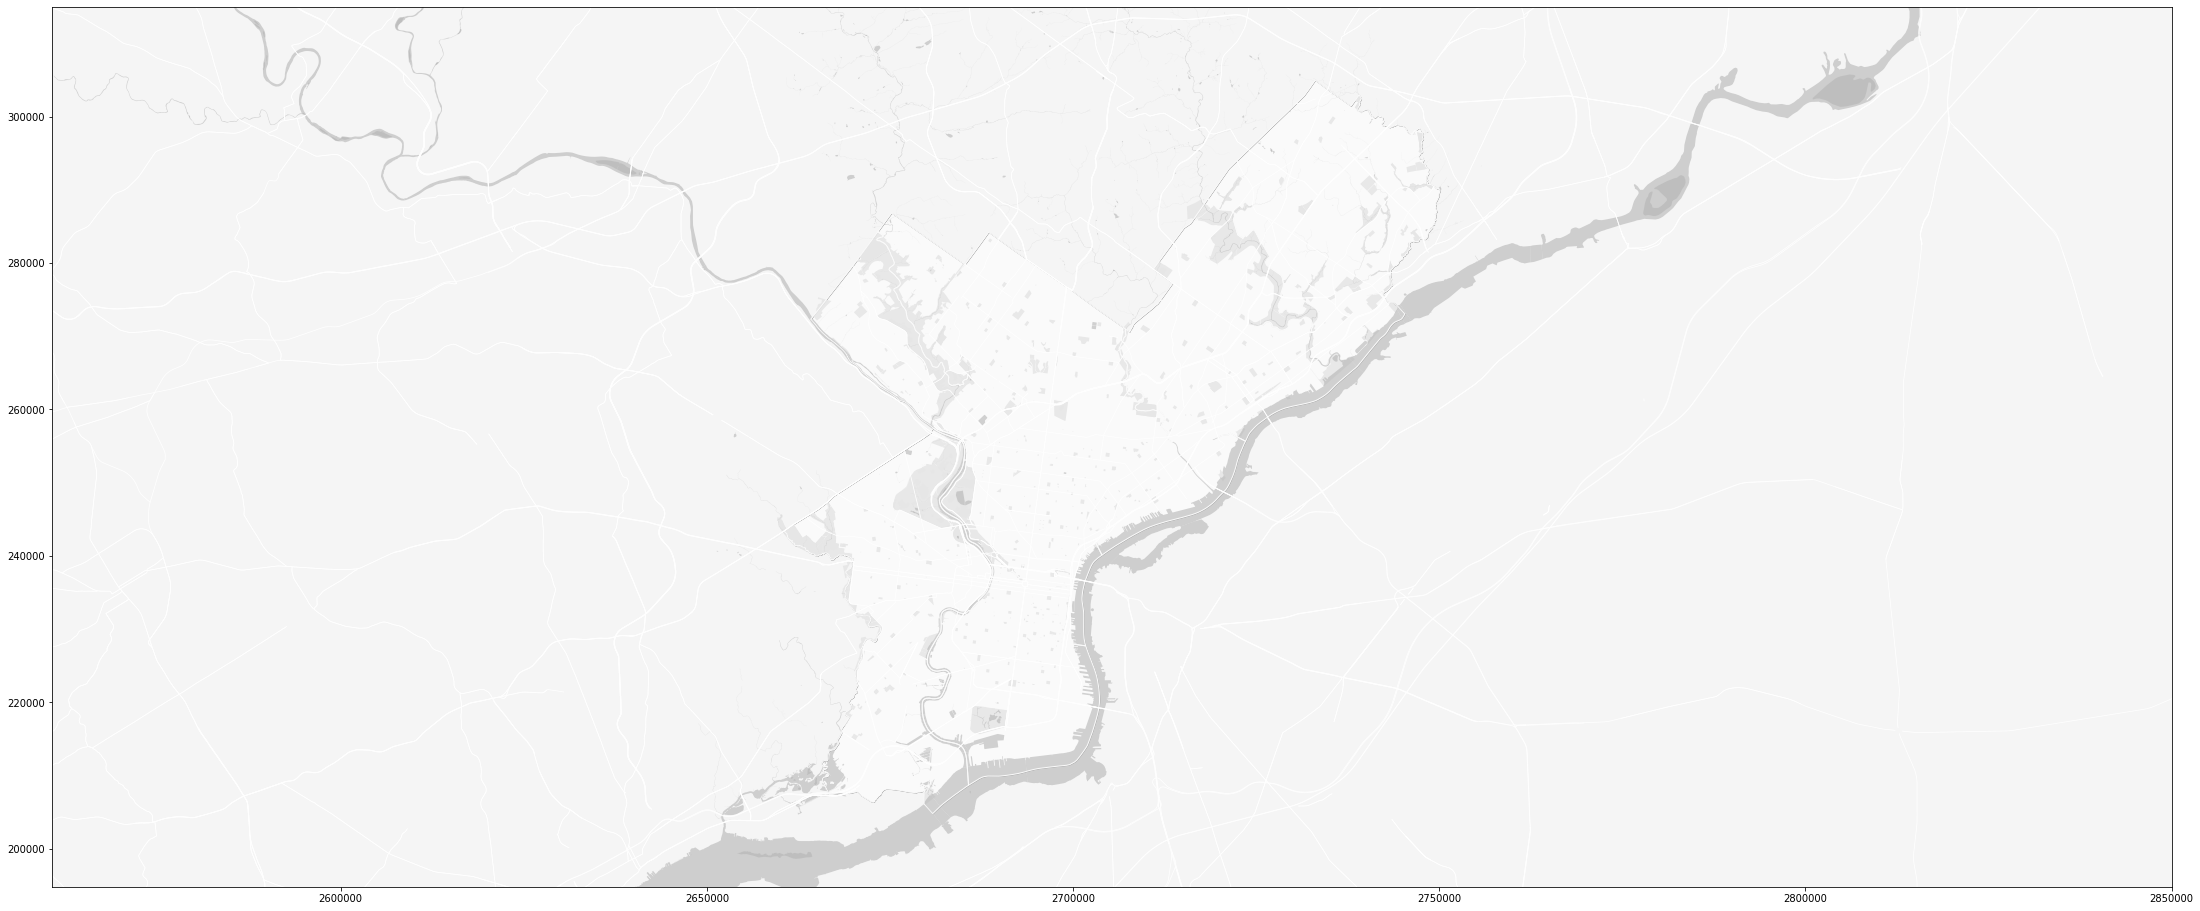

In [144]:
fig, ax = plt.subplots(figsize=(38,20))
# morans_hh_0010.plot(color='white',edgecolor='#E6E6E6',linewidth=0.1,ax=ax,)
ax.set_facecolor("whitesmoke")

paroads_all.plot(ax=ax, color="white",linewidth=0.75)
njroads_all.plot(ax=ax, color="white",linewidth=0.75)
# roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3)
# roads_formap.plot(ax=ax, color="lightgrey", alpha=.3)
city.plot(ax=ax, color="white", edgecolor="k", linewidth=.5,alpha=0.5)
parks.plot(ax=ax,color="#E6E6E6",edgecolor='none', alpha=0.9)
water_all.plot(ax=ax, color="#B4B4B4", edgecolor='none', alpha=0.6);

# deeds[(deeds['sort_year_x']==2018)].plot(ax=ax,color="black",markersize=0.3,alpha=0.6)

# deeds[(deeds['sort_year_x']==2018) & (deeds['investor_all']==1)].plot(ax=ax,color="black",markersize=0.3,alpha=0.6)
districts.plot(ax=ax,facecolor='none',edgecolor='#FAFAFA',linewidth=1, alpha=1);

# districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], 
#                                       ha='center',fontname="Akkurat Pro", backgroundcolor = "white",fontsize=8,color='#5A5A5A',alpha=0.2),axis=1); 
# northphilly.plot(ax=ax,facecolor='#E6E6E6',edgecolor='#646464',linewidth = 2,alpha=0.4)
# westPhilly.plot(ax=ax,facecolor='#E6E6E6',edgecolor='#646464',alpha=0.4)
# germantown.plot(ax=ax,facecolor='#E6E6E6',edgecolor='#646464',alpha=0.4)
# northphilly.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0], 
#                                       ha='center',fontname="Akkurat Pro", backgroundcolor = "none",fontsize=15,color='#646464',alpha=1),axis=1); 
# westPhilly.apply(lambda x: ax.annotate(s=x.alt_name, xy=x.geometry.centroid.coords[0], 
#                                       ha='center',fontname="Akkurat Pro", backgroundcolor = "none",fontsize=15,color='#646464',alpha=1),axis=1); 
# germantown.apply(lambda x: ax.annotate(s=x.alt_name, xy=x.geometry.centroid.coords[0], 
#                                       ha='center',fontname="Akkurat Pro", backgroundcolor = "none",fontsize=15,color='#646464',alpha=1),axis=1); 


ax.set_xlim(xlim_wide)
ax.set_ylim(ylim_wide)
plt.savefig("../05_drawings/neighborhood_key_blank.png",dpi=500)

# ax.set_axis_off()

In [49]:
sum_overlap0010 = morans_hh_0010[['overlap00',
       'overlap01', 'overlap02', 'overlap03', 'overlap04', 'overlap05',
       'overlap06', 'overlap07', 'overlap08', 'overlap09']].sum()

sum_hh0010 = morans_hh_0010[['inv_hh00', 'inv_hh01', 
       'inv_hh02', 'inv_hh03',  'inv_hh04',
       'inv_hh05',  'inv_hh06', 'inv_hh07',
       'inv_hh08', 'inv_hh09',]].sum()

sum_overlap1018 = morans_hh_1018[['overlap10',
       'overlap11', 'overlap12', 'overlap13', 'overlap14', 'overlap15',
       'overlap16', 'overlap17', 'overlap18']].sum()

sum_hh1018 = morans_hh_1018[['inv_hh10', 'inv_hh11', 
       'inv_hh12', 'inv_hh13',  'inv_hh14',
       'inv_hh15',  'inv_hh16', 'inv_hh17',
       'inv_hh18', ]].sum()

In [132]:
sum_hh1018

inv_hh10     926
inv_hh11     976
inv_hh12     778
inv_hh13     598
inv_hh14     929
inv_hh15    1449
inv_hh16    1559
inv_hh17    1842
inv_hh18    2219
dtype: int64

In [107]:
sum_hh0010

inv_hh00     936
inv_hh01    1030
inv_hh02    1321
inv_hh03    1617
inv_hh04    1610
inv_hh05    1580
inv_hh06    1877
inv_hh07    1391
inv_hh08    1169
inv_hh09     841
dtype: int64

In [130]:
sum_overlap0010/(non_res.shape[0])

overlap00    0.039949
overlap01    0.033412
overlap02    0.034138
overlap03    0.030870
overlap04    0.024514
overlap05    0.025785
overlap06    0.010350
overlap07    0.029962
overlap08    0.023969
overlap09    0.010532
dtype: float64

In [131]:
sum_overlap1018/(non_res.shape[0])

overlap10    0.017069
overlap11    0.016343
overlap12    0.021790
overlap13    0.024151
overlap14    0.040312
overlap15    0.042491
overlap16    0.024696
overlap17    0.033957
overlap18    0.015435
dtype: float64

In [129]:
non_res.shape

(5507, 97)

In [117]:
res_blocks = gpd.sjoin(res_c,morans_hh_1018,op='within',how='right')
non_res = res_blocks[res_blocks['C_DIG1DESC'].isnull()]

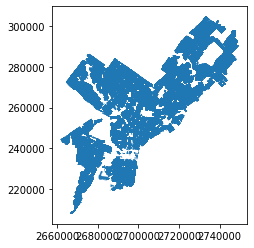

In [121]:
res_blocks[res_blocks['C_DIG1DESC'].notnull()].plot()

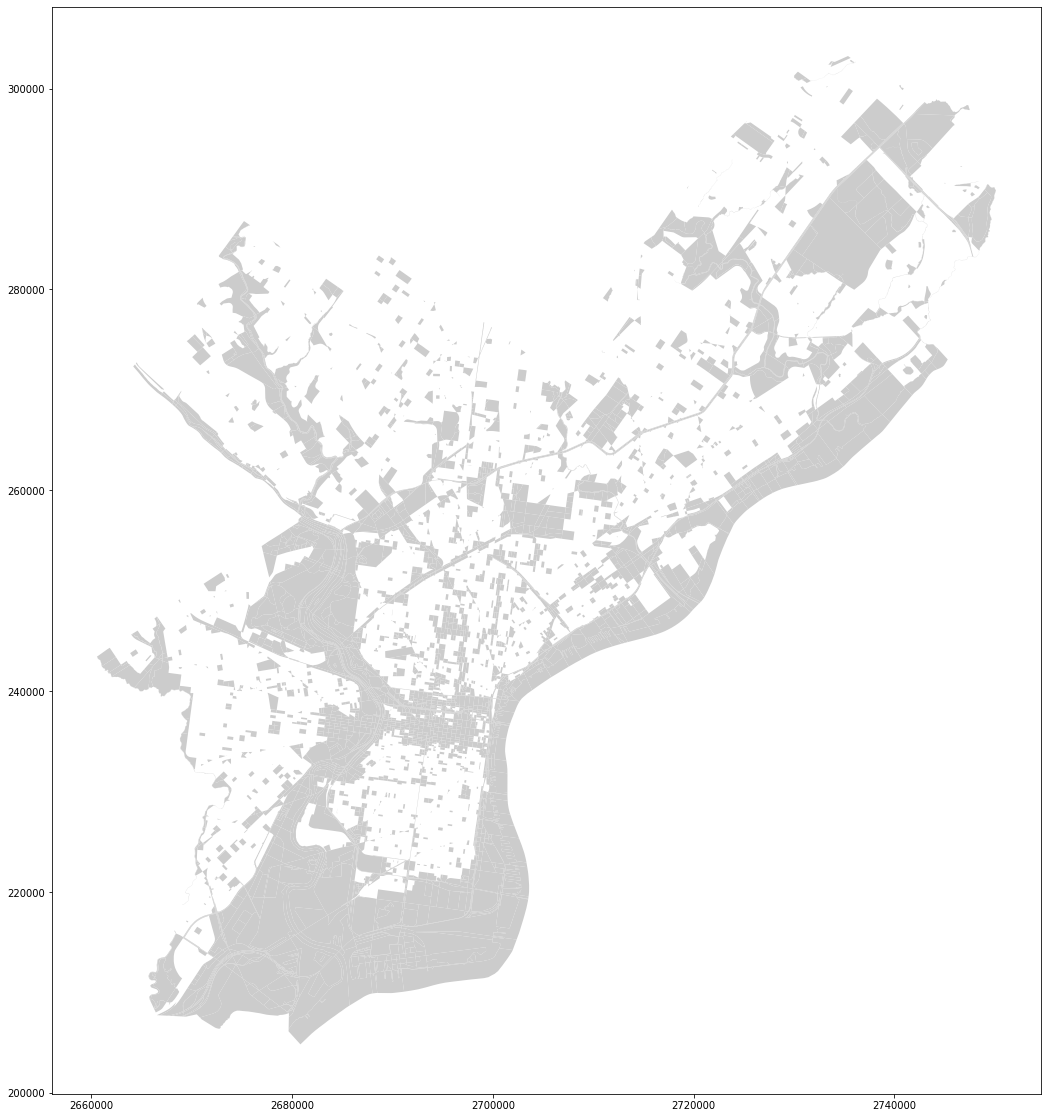

In [124]:
non_res.plot(figsize=(20,20),color='#cccccc')